# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

homeo_method = 'HEH'
tag = 'autoencoder'
matname = tag +'_' + homeo_method

nb_quant = 128
nb_quant = 256
C = 5.
eta_homeo=0.05
alpha_homeo=0.02
do_double_shuffle = True
do_double_shuffle = False
do_random = True

n_iter = 2**13 + 1

record_num_batches = 2**11
N_show = 120
max_patches = 10
seed = 42
np.random.seed(seed)

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            homeo_method=homeo_method, eta_homeo=eta_homeo, alpha_homeo=alpha_homeo, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)


In [4]:
from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname='autoencoder')

Extracting data..loading the data called : data_cache/autoencoder_data
Data is of shape : (81920, 144) - done in 0.27s.


In [5]:
!ls -l {shl.data_cache}/{tag}*
!rm -fr {shl.data_cache}/{tag}*lock*

-rw-r--r--  1 laurentperrinet  staff   2535129 Feb 15 14:29 data_cache/autoencoder_HEH_dico.pkl
-rw-r--r--  1 laurentperrinet  staff   1451678 Feb 15 15:05 data_cache/autoencoder_None_dico.pkl
-rw-r--r--  1 laurentperrinet  staff  94371968 Feb 15 09:38 data_cache/autoencoder_data.npy


In [6]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 144)
average of patches =  -4.431043240318946e-05  +/-  0.0068778821454161
average energy of data =  0.05828109085595273 +/- 0.0693543287266958


In [7]:
l0_sparseness = shl.l0_sparseness
l0_sparseness_noise = 200 #shl.n_dictionary #
#l0_sparseness_high = shl.l0_sparseness * 2
shl.do_precision

False

In [8]:
stick = np.arange(shl.n_dictionary)*nb_quant

indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

loading the dico called : data_cache/autoencoder_HEH_dico.pkl


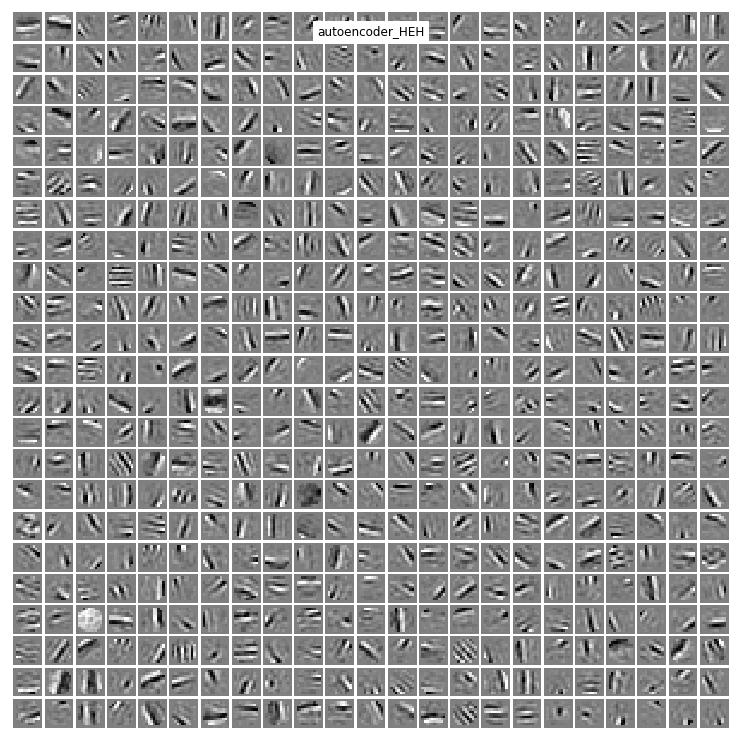

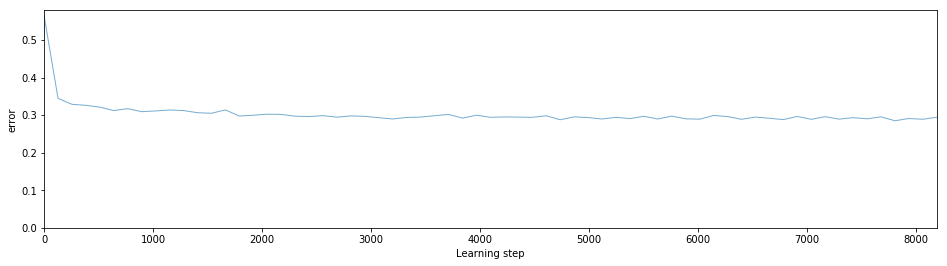

In [9]:
list_figures = ['show_dico', 'time_plot_error']#, 'time_plot_logL']

dico_homeo = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico_homeo.dictionary.shape)
print('average of filters = ',  dico_homeo.dictionary.mean(axis=1).mean(), 
      '+/-',  dico_homeo.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico_homeo.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  8.093717339753083e-05 +/- 0.007294503713407034
average energy of filters =  1.0 +/- 8.191786740958827e-17


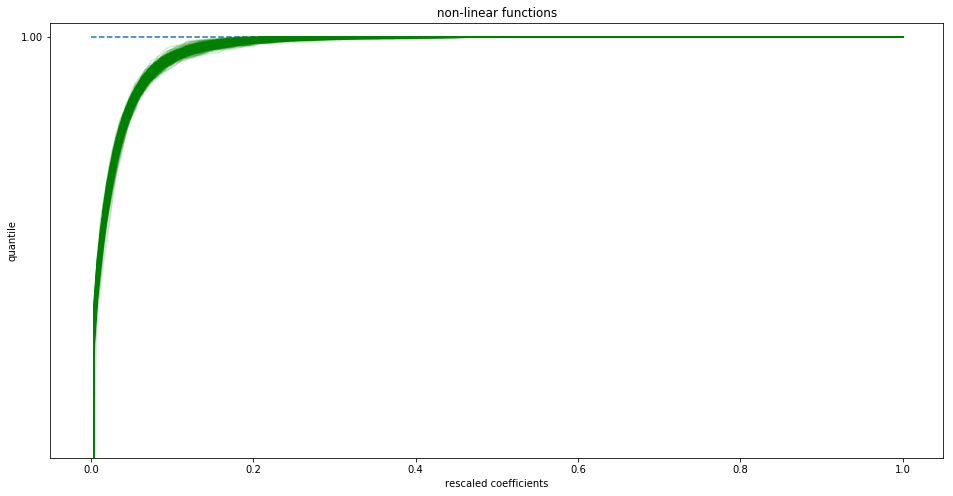

In [11]:
if not dico_homeo.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico_homeo.P_cum, verbose=False, alpha=.15);
    ax.set_ylim(0.97, 1.001)
    #ax.set_xmargin(0.);

## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [12]:
from shl_scripts.shl_tools import show_data
def print_stats(data, dictionary, sparse_code):
    print(42*'🐒')
    patches = sparse_code @ dictionary
    error = data - patches

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

    print('number of codes, size of reconstructed images = ', patches.shape)

    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[:max_patches, :])
    plt.show()
    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data**2, axis=1))
    #SD = np.linalg.norm(data[indx, :])/record_num_batches

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    #print('total energy of data = ', np.sqrt(np.sum(data**2)))
    #print('total deviation of data = ', np.sum(np.abs(data)))
    
    SE = np.sqrt(np.mean(error**2, axis=1))
    #SE = np.linalg.norm(error)/record_num_batches

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
    #print('total deviation of residual = ', np.sum(np.abs(error)))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    #print('average gain of coding = ', data[indx, :].std()/error.std())  
    
    return SD, SE

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.0039715452223632024
average std of codewords =  0.043834854562352386
l0-sparseness of codewords =  0.028287083530245748  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0011024026873845698
number of codes, size of reconstructed images =  (2048, 144)


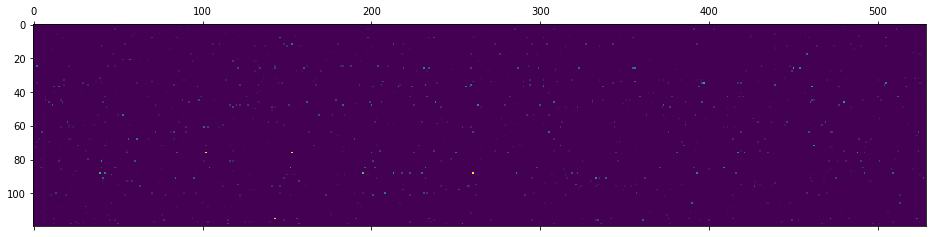

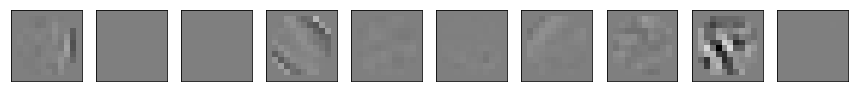

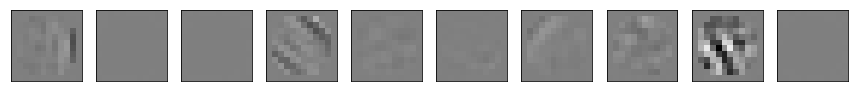

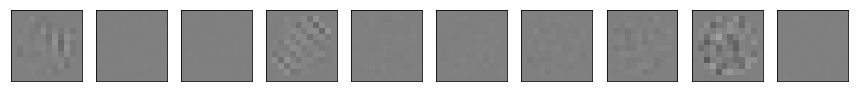

average of data patches =  4.348051482348567e-05 +/- 0.006304082270561583
average of residual patches =  6.913014012328099e-05 +/- 0.002668609622336088
median energy of data =  0.027811578620636768
average energy of data =  0.05623149364347031 +/- 0.06821557723632118
average energy of residual =  0.0168799082124734 +/- 0.02071405498864561
median energy of residual =  0.008266947251127433
average gain of coding =  3.525310650055361 +/- 0.8978609974297058
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.0039715452223632024
average std of codewords =  0.04383485456235239
l0-sparseness of codewords =  0.028287083530245748  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0011024026873845698
number of codes, size of reconstructed images =  (2048, 144)


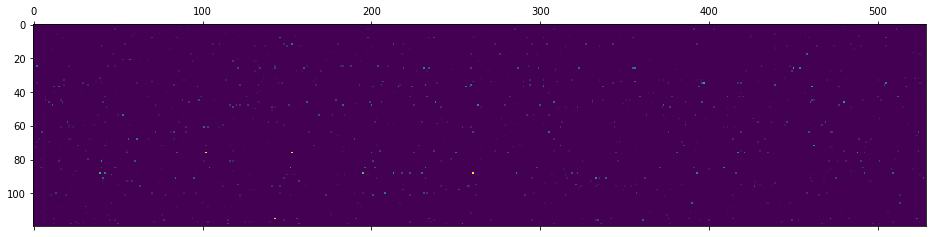

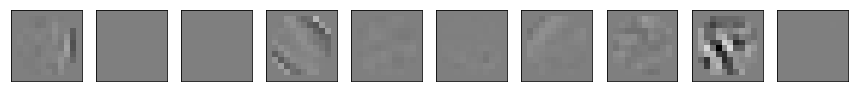

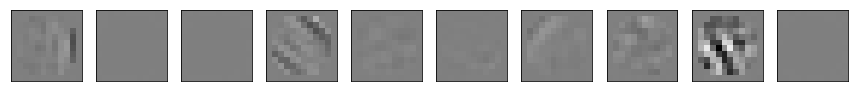

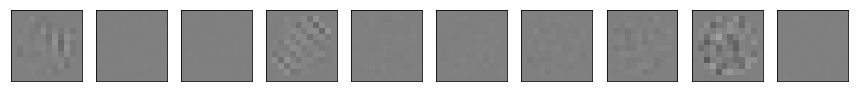

average of data patches =  4.348051482348567e-05 +/- 0.006304082270561583
average of residual patches =  6.913014012328121e-05 +/- 0.002668609622336088
median energy of data =  0.027811578620636768
average energy of data =  0.05623149364347031 +/- 0.06821557723632118
average energy of residual =  0.0168799082124734 +/- 0.02071405498864561
median energy of residual =  0.008266947251127433
average gain of coding =  3.525310650055361 +/- 0.8978609974297058
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.003997704369552895
average std of codewords =  0.043696577358331525
l0-sparseness of codewords =  0.02829539077268431  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0012353085406047472
number of codes, size of reconstructed images =  (2048, 144)


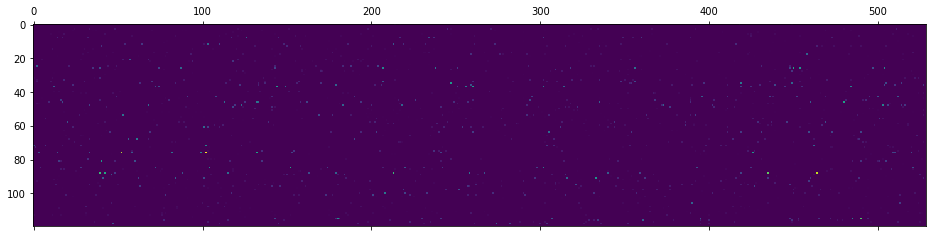

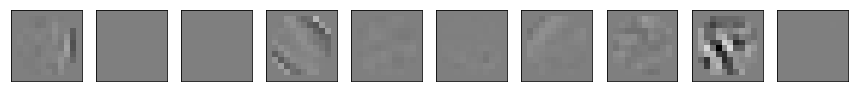

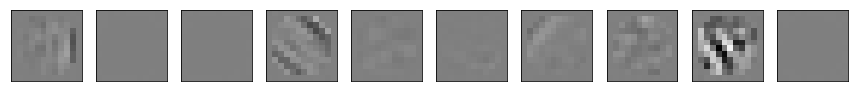

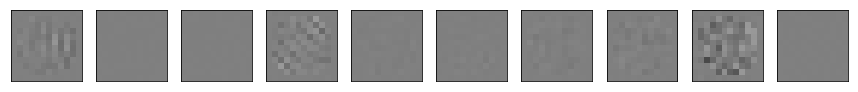

average of data patches =  4.348051482348567e-05 +/- 0.006304082270561583
average of residual patches =  -2.4894919743127944e-05 +/- 0.002899043288360664
median energy of data =  0.027811578620636768
average energy of data =  0.05623149364347031 +/- 0.06821557723632118
average energy of residual =  0.01739468711816065 +/- 0.02120407438104438
median energy of residual =  0.008652498762150435
average gain of coding =  3.424200924765801 +/- 0.8825223232480257


In [13]:
from shl_scripts.shl_encode import sparse_encode
if dico_homeo.P_cum is None: 
    gain = np.ones(shl.n_dictionary)
else:
    gain = None
dico_rec = dico_homeo.dictionary

for P_cum_rec, gain_rec in zip([None, P_cum_zeroeffect, dico_homeo.P_cum], [np.ones(shl.n_dictionary), None, gain]):
    sparse_code = sparse_encode(data[indx, :], dico_rec, P_cum=P_cum_rec, C=C, 
                                 l0_sparseness=l0_sparseness, gain=gain_rec)   

    SD, SE = print_stats(data[indx, :], dico_homeo.dictionary, sparse_code)

## Generating new coefficients by shuffling and decoding

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [ 50  67  82  38  58  59  47  43  36  52  54  44  76  26  37  32  42  92
  48  34  46  48  38  53  56  81  43  56  47  46  51 107  58 109  44  54
  54 108  48  67  51  45  40  66  46 110  50  68 124  85  69  28  24  84
  54  38  30 105  58  37  54  74  54  61  31  64  48  39  44  70  58  42
  36  45  52  59  65  35  96 101  52  41  54  44  88  52 130  

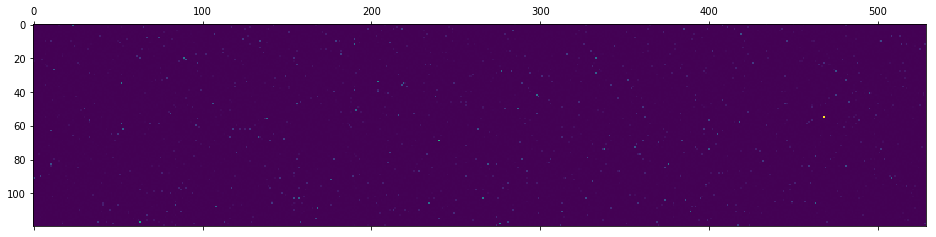

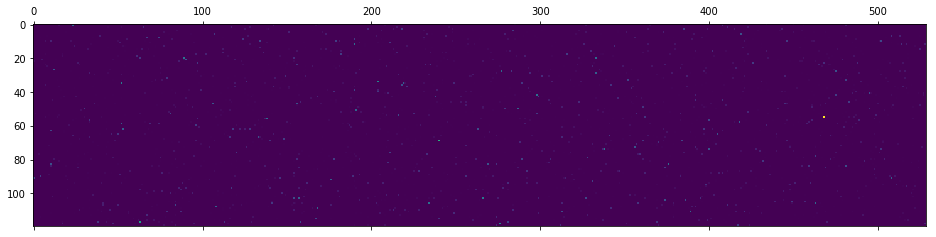

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [58 54 68 52 56 45 39 62 56 59 61 50 56 63 61 58 66 56 35 61 49 66 51 57
 52 52 56 56 54 67 55 46 58 67 67 70 57 60 70 49 60 60 54 69 62 64 66 52
 54 59 60 41 55 55 61 67 55 40 54 73 43 48 58 64 58 54 52 53 53 55 53 56
 66 55 49 53 65 48 63 63 67 71 51 57 64 42 73 55 61 55 63 48 58 60 63 51
 54 58 70 48 53 51 66 57 50 48 62 52 54 42 60 46 64 60 48 47 5

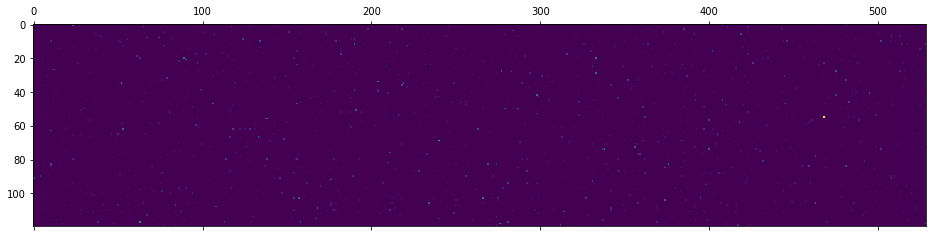

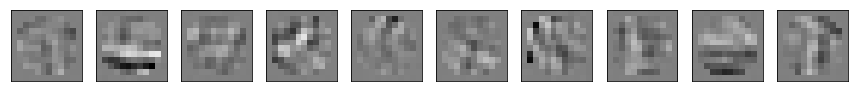

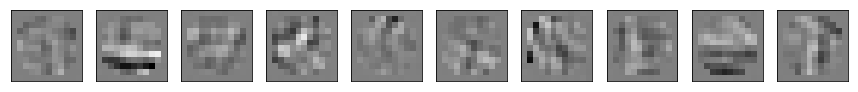

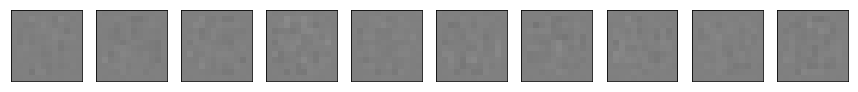

average of data patches =  0.0003052310565678985 +/- 0.006642714015470962
average of residual patches =  4.955590512665465e-06 +/- 0.0012583852551523932
median energy of data =  0.06672670126572375
average energy of data =  0.07440764852000156 +/- 0.03626525884878512
average energy of residual =  0.008934813333052724 +/- 0.0040195631703123244
median energy of residual =  0.007898886522309252
average gain of coding =  8.857090816985762 +/- 4.414079539936236


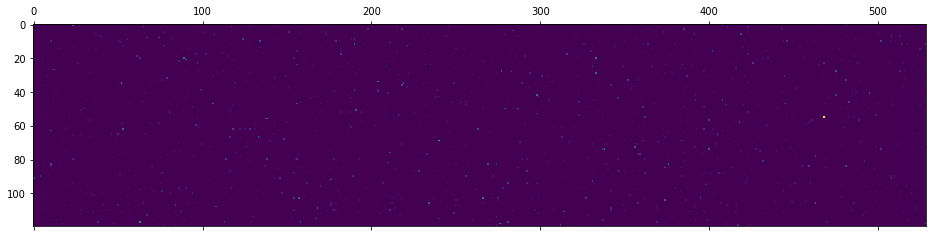

mean deviation of coefficients =  0.013696304409833208 0.00422336151491943 0.004244146248794393
total deviation of coefficients =  0.00266210737509972
mean deviation of quantiles =  0.007214349767155704
mean deviation of quantiles =  0.007146262797024226
total deviation of quantiles =  0.00887317915477732
ratio deviation of quantiles =  1.2299347052971648
proba incorrect coefficients =  0.9719519804465974
proba incorrect coefficients (strong) =  0.03502610320179589


In [14]:
def shuffling(data, sparse_code, dico):
    if do_random:
        from shl_scripts.shl_encode import inv_quantile, inv_rescaling
        sparse_code_bar = inv_rescaling(inv_quantile(dico.P_cum, np.random.rand(sparse_code.shape[0], sparse_code.shape[1])), C=C)
    else:
        sparse_code = sparse_encode(data, dico.dictionary, P_cum=dico.P_cum, C=C, 
                                     l0_sparseness=l0_sparseness_noise, gain=None)   

        sparse_code_bar = sparse_code.copy()
        
        sparse_code_bar = sparse_code_bar.T
        np.random.shuffle(sparse_code_bar)
        sparse_code_bar = sparse_code_bar.T
        
        if do_double_shuffle:
            np.random.shuffle(sparse_code_bar)


    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code, axis=0)[:N_show])

    print(sparse_code_bar.shape)

    plt.matshow(sparse_code_bar[:N_show, :])
    plt.show()

    def threshold(sparse_code, l0_sparseness):
        thr = np.percentile(sparse_code, 100 * (1 - l0_sparseness/shl.n_dictionary ), axis=1)
        return (sparse_code>thr[:, np.newaxis])

    sparse_code_bar_high = threshold(sparse_code_bar, l0_sparseness) * sparse_code_bar
    plt.matshow(sparse_code_bar_high[:N_show, :])
    plt.show()
    return sparse_code_bar, sparse_code_bar_high

def pipeline(sparse_code_bar, sparse_code_bar_high, dico, index):

    patches_bar = sparse_code_bar @ dico.dictionary
    SD = np.sqrt(np.mean(patches_bar**2, axis=1))


    P_cum_rec = dico.P_cum
    if P_cum_rec is None: 
        gain_rec = np.ones(shl.n_dictionary)
    else:
        gain_rec = None

    sparse_code_rec = sparse_encode(patches_bar, dico.dictionary, P_cum=P_cum_rec, C=C, 
                                     l0_sparseness=l0_sparseness, gain=gain_rec)   

    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_bar_high, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_rec, axis=0)[:N_show])
    
    
    SD, SE = print_stats(patches_bar, dico.dictionary, sparse_code_rec)
    
    plt.matshow(sparse_code_rec[:N_show, :])
    plt.show()

    print('mean deviation of coefficients = ', np.mean(np.abs(sparse_code_bar)), np.mean(np.abs(sparse_code_bar_high)), np.mean(np.abs(sparse_code_rec)))
    print('total deviation of coefficients = ', np.mean(np.abs(sparse_code_bar_high-sparse_code_rec)))

    if not dico.P_cum is None: 
        from shl_scripts.shl_encode import quantile, rescaling

        q_rec = quantile(dico.P_cum, rescaling(sparse_code_rec, C=C), stick, do_fast=False)
        q_bar = quantile(dico.P_cum, rescaling(sparse_code_bar_high, C=C), stick, do_fast=False)

        print('mean deviation of quantiles = ', np.mean(np.abs(q_bar)))
        print('mean deviation of quantiles = ', np.mean(np.abs(q_rec)))
        print('total deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec)))
        print('ratio deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar)))
        aerror = np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar))
    else:
        aerror = np.nan

    perror = 1 - np.mean( (sparse_code_bar>0) == (sparse_code_rec>0))
    print('proba incorrect coefficients = ', perror)

    perror_high = 1 - np.mean( (sparse_code_bar_high > 0) == (sparse_code_rec>0))
    print('proba incorrect coefficients (strong) = ', perror_high)
    
    return pd.DataFrame({'error':[(SD/SE).mean()],
                               'aerror':[aerror],
                               'perror':[perror],
                               'perror_high':[perror_high]
                                        },
                                index=[index])

sparse_code_bar, sparse_code_bar_high = shuffling(data[indx, :], sparse_code, dico_homeo)
record = pipeline(sparse_code_bar, sparse_code_bar_high, dico_homeo, index='homeo')

In [15]:
record

,aerror,error,perror,perror_high
homeo,1.229935,8.857091,0.971952,0.035026


## comparing to the learning without homeostasis

Extracting data..loading the data called : data_cache/autoencoder_data
Data is of shape : (81920, 144) - done in 0.13s.
loading the dico called : data_cache/autoencoder_None_dico.pkl


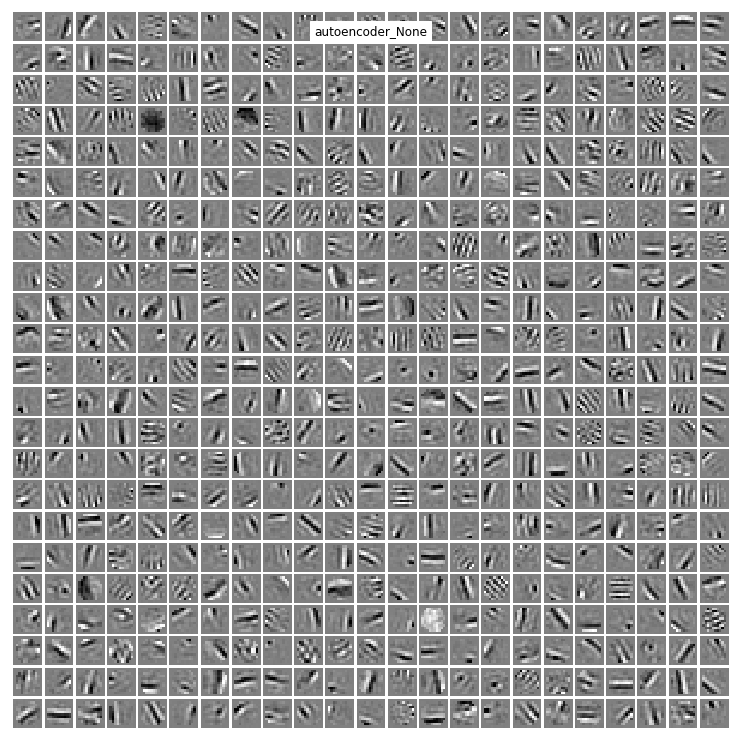

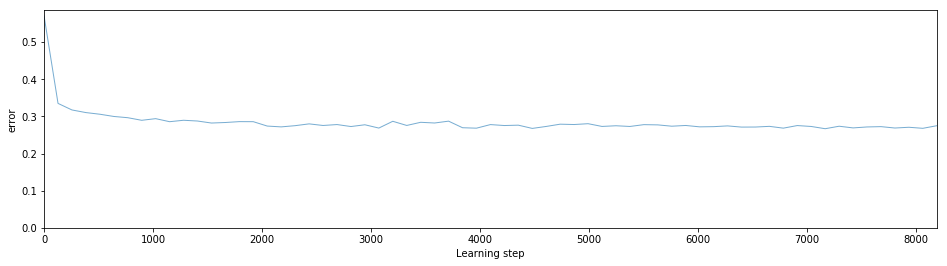

In [16]:
homeo_method = 'None'
matname = 'autoencoder_' + homeo_method

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            homeo_method=homeo_method, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)

from shl_scripts.shl_experiments import SHL
shl_nohomeo = SHL(**opts)
data = shl_nohomeo.get_data(matname='autoencoder')
dico_nohomeo = shl_nohomeo.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [17]:
if not dico_nohomeo.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico_nohomeo.P_cum, verbose=False, alpha=.15);
    ax.set_ylim(0.85, 1.01)
    #ax.set_xmargin(0.);

### coding


🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.003974520841572059
average std of codewords =  0.04421692607663767
l0-sparseness of codewords =  0.028317543419187144  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0011493051909066611
number of codes, size of reconstructed images =  (2048, 144)


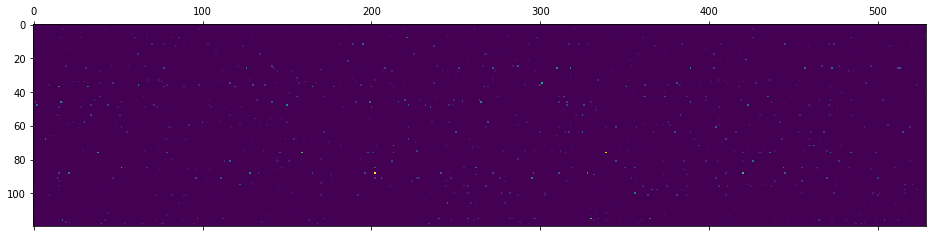

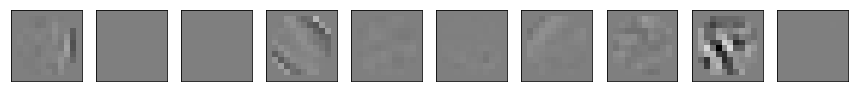

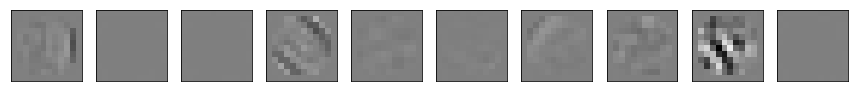

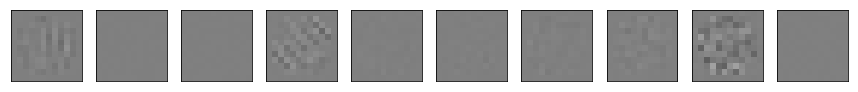

average of data patches =  4.348051482348567e-05 +/- 0.006304082270561583
average of residual patches =  -1.1447031591733162e-05 +/- 0.0023430689245461833
median energy of data =  0.027811578620636768
average energy of data =  0.05623149364347031 +/- 0.06821557723632118
average energy of residual =  0.01580256807579804 +/- 0.01844219011660335
median energy of residual =  0.008054542959617834
average gain of coding =  3.668098119171857 +/- 0.9690385323861996


(array([0.0308, 0.0001, 0.0001, ..., 0.1454, 0.1247, 0.0023]),
 array([0.013 , 0.    , 0.    , ..., 0.0483, 0.0408, 0.0005]))

In [18]:
P_cum_rec = None 
gain_rec = np.ones(shl_nohomeo.n_dictionary)
dico_rec = dico_nohomeo.dictionary

sparse_code = sparse_encode(data[indx, :], dico_rec, P_cum=P_cum_rec, C=C, 
                                 l0_sparseness=l0_sparseness, gain=gain_rec)   

print_stats(data[indx, :], dico_nohomeo.dictionary, sparse_code)

### Generating and shuffling the coefficients

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [58 54 68 52 56 45 39 62 56 59 61 50 56 63 61 58 66 56 35 61 49 66 51 57
 52 52 56 56 54 67 55 46 58 67 67 70 57 60 70 49 60 60 54 69 62 64 66 52
 54 59 60 41 55 55 61 67 55 40 54 73 43 48 58 64 58 54 52 53 53 55 53 56
 66 55 49 53 65 48 63 63 67 71 51 57 64 42 73 55 61 55 63 48 58 60 63 51
 54 58 70 48 53 51 66 57 50 48 62 52 54 42 60 46 64 60 48 47 5

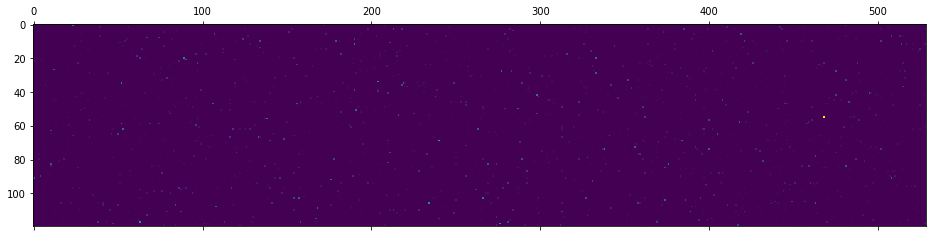

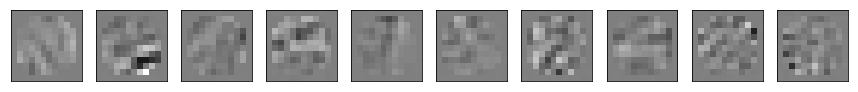

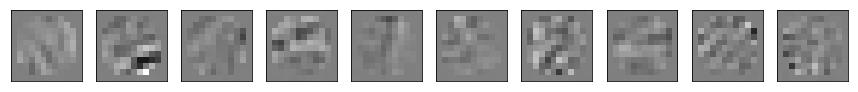

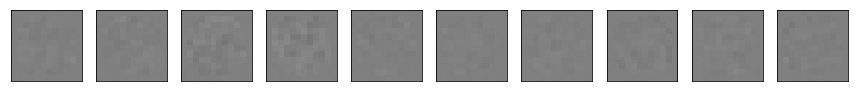

average of data patches =  -2.2992344404406733e-05 +/- 0.007303896018446757
average of residual patches =  6.672504126645959e-05 +/- 0.0009207895226673388
median energy of data =  0.06633922312435431
average energy of data =  0.07431267383805007 +/- 0.03633127854348473
average energy of residual =  0.008001332141380126 +/- 0.002992198980374711
median energy of residual =  0.0072898944753385705
average gain of coding =  9.698993863975561 +/- 4.708828879143566


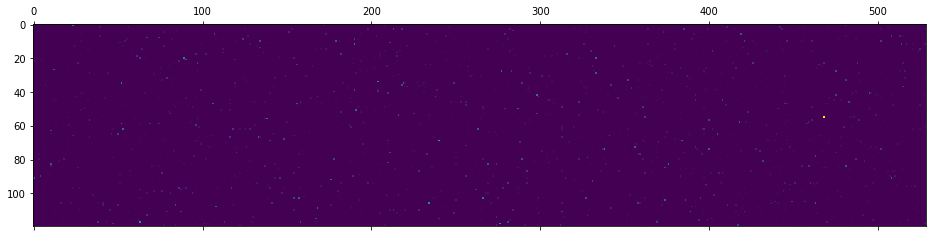

mean deviation of coefficients =  0.013696304409833208 0.00422336151491943 0.004219837995811171
total deviation of coefficients =  0.002220615193670034
proba incorrect coefficients =  0.972085819352552
proba incorrect coefficients (strong) =  0.03225794541587901


,aerror,error,perror,perror_high
homeo,1.229935,8.857091,0.971952,0.035026
nohomeo,NaN,9.698994,0.972086,0.032258


In [19]:
pd.concat([record, pipeline(sparse_code_bar, sparse_code_bar_high, dico_nohomeo, index='nohomeo')])

## Version used

In [20]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.0
shl_scripts 20171221
pandas 0.22.0
Fri Feb 16 09:18:51 2018 CET